# A comparison of expected 10k cohort thrombolysis rates across hospitals: subgroup analysis

## Plain English summary

We may predict the use of thrombolysis across hospitals if all hospital saw the same 10 thousand patients. We can also look at groups of those patients, representing 'ideal' thrombolysis candidates, milder strokes, strokes without a precisely known stroke onset time, or with existing pre-stroke disability. 

All stroke units show high expected thrombolysis in a set of 'ideal' thrombolysis patients, but vary in expected use in subgroups with low stroke severity, no precise onset time, or existing pre-stroke disability. If a stroke unit showed lower  thombolysis in one of these subgroups they also tended to show lower thrombolysis rates in the other subgroups - suggesting a shared caution in use of thrombolysis in 'less ideal' patients.

## Model and data

An XGBoost model is trained on all but a 10k patient cohort, to predict which patient will recieve thrombolysis.The 10k patient cohort is then used in two ways: 1) as the test set for the model fitting process 2) as a common set of patients that are sent to each hospital in turn to obtain a thrombolysis rate that is comparable across hospitals which has any patient factors removed.

The XGBoost model is fitted to all but 10k instances, and uses 10 features: 

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Recieve thrombolysis (1 = Yes, 0 = No)

The 10 features included in the model (to predict whether a patient will recieve thrombolysis) were chosen sequentially as having the single best improvement in model performance (using the ROC AUC). The stroke team feature is included as a one-hot encoded feature.

## Aims:

* Train XGBoost model on all data except for a 10k set of patients
* Predict use of thrombolysis in the heldback 10k cohort of patients, at each of the 132 hospitals (by changing hospital one-hot coding).
* Predict use of thrombolysis in subgroups of patients, defined by:
  * Mild stroke severity (NIHSS < 5)
  * No precise onset time
  * Existing pre-stroke disability (mRS > 2)
  * Older than 80 years old
  * Arrival-to-scan time 60-90 minutes
  * Use of AF anticoagulants
  * An *ideal* thrombolysable patient:
    * Stroke severity NIHSS in range 10-25
    * Arrival-to-scan time < 30 minutes
    * Stroke type = infarction
    * Precise onset time = True
    * Prior diability level (mRS) = 0
    * No use of AF anticoagulants
    * Onset-to-arrival time < 90 minutes
    * Age < 80 years
    * Onset during sleep = False

## Observations

* The 10k cohort may be grouped to show thrombolysis in particular groups

* Those hospitals with lower thrombolysis use, compared with their total thrombolysis use, in three subsets of patients (NIHSS < 5, mRS >2, no precise onset time) tend to have signficantly lower overal thrombolysis use in the full 10k patients.

* When testing the 'ideal' thrombolysable patients, 95% of hospitals would be expected to give thrombolysis to at least 99% of patients. 

* The range of thrombolysis use across hopsitals in the other subgroups was as follows:
  * All 10k patients: minimum = 10%, median = 28%, maxiumum = 45%
  * NIHSS <5: : minimum = 0%, median = 6%, maxiumum = 25%
  * No precise onset time: : minimum = 0%, median = 7%, maxiumum = 20%
  * Prestroke mRS >2: : minimum = 0%, median = 11%, maxiumum = 38%

* The three subgroups of NIHSS <5, no precise stroke onset time, and prestroke mRS > 2, showed quite high pairwise correlations (r-squared 0.45 to 0.62). The three subgorups also showed quite strong correlation with the expected thrombolysis rate across all 10k patients (r-squared 0.68 to 0.77)

* Almost all stroke units show high expected thrombolysis in a set of 'ideal' thrombolysis patients, but vary in expected use in subgroups with low stroke severity, no precise onset time, or existing pre-stroke disability. If a stroke unit showed lower  thombolysis in one of these subgroups they also tended to show lower thrombolysis rates in the other subgroups - suggesting a shared caution in use of thrombolysis in 'less ideal' patients. Combination of non-ideal features significantly surpress use of thrombolysis futher.

## Import libraries

In [49]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import pickle
import shap

from scipy import stats

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression

from xgboost import XGBClassifier

from os.path import exists
import json

import importlib

# Import local package
from utils import waterfall
# Force package to be reloaded
importlib.reload(waterfall);

## Set filenames

In [50]:
# Set model type (used in file save, e.g. xgb_combined_calibrated_oversampled)
number_key_features = 10
model_text = f'xgb_{number_key_features}_features_10k_cohort'
notebook = '15'

## Create output folders if needed

In [51]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [52]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

10k cohort of patients in test data, rest in training data

In [53]:
data_loc = '../data/10k_training_test/'

In [54]:
# Load data
train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

# Read in the names of the selected features for the model
number_of_features_to_use = 10
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# Select features
train = train[key_features]
train.rename(columns=dict_feature_name, inplace=True)
test = test[key_features]
test.rename(columns=dict_feature_name, inplace=True)

Store admissions per hospital

In [55]:
df_admissions = (
    pd.DataFrame(index=np.unique(train["Stroke team"], return_counts=True)[0]))
df_admissions[f"Admissions"] = (
    np.unique(train["Stroke team"], return_counts=True)[1])

Format data

In [56]:
# Get X and y
X_train = train.drop('Thrombolysis', axis=1)
X_test = test.drop('Thrombolysis', axis=1)
y_train = train['Thrombolysis']
y_test = test['Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('Stroke team', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('Stroke team', axis=1, inplace=True)    

## Read XGBoost model

Read XGBoost model fitted on the 10k cohort train/test dataset (from notebook 04)

In [57]:
%%time

filename = (f'./saved_models/04_{model_text}.p')
file_exists = exists(filename)

if file_exists:
    # Load model interaction
    with open(filename, 'rb') as filehandler:
        model = pickle.load(filehandler)
else:
    print("Run notebook 04")

# Get predicted probabilities and class
y_probs = model.predict_proba(X_test)[:,1]
y_pred = y_probs > 0.5

# Show accuracy
accuracy = np.mean(y_pred == y_test)
print (f'Accuracy: {accuracy:.3f}')

Accuracy: 0.848
CPU times: user 58.2 ms, sys: 1.41 ms, total: 59.7 ms
Wall time: 15 ms


Calculate receiver operating characteristic curve area under curve.

In [58]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
print (f'ROC ACUC: {roc_auc:.3f}')

ROC ACUC: 0.915


### Pass 10k cohort through all hospital models and get thrombolysis rate

For each hospital, set all of the 10k patients in the test set as attending that hospital, and calculate the thrombolysis rate. This will give a thrombolysis rate for each hospital with patient variation removed, and only hospital factors remaining.

In [59]:
hospitals = list(set(train['Stroke team']))
hospitals.sort()
thrombolysis_rate = []
single_predictions = []

# For each hospital
for hospital in hospitals:
    
    # Get test data without thrombolysis hospital or stroke team
    X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)
    
    # Copy hospital dataframe and change hospital ID (after setting all to zero)
    X_test_adjusted_hospital = X_test_hosp.copy()
    X_test_adjusted_hospital.loc[:,:] = 0
    team = "team_" + hospital
    X_test_adjusted_hospital[team] = 1
    
    X_test_adjusted = pd.concat(
        [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
    
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test_adjusted)[:,1]
    y_pred = y_probs > 0.5
    thrombolysis_rate.append(y_pred.mean())
    
    # Save predictions
    single_predictions.append(y_pred * 1)

In [60]:
# Convert individual predictions (a list of arrays) to a NumPy array, and 
#   transpose
patient_results = np.array(single_predictions).T
# Convert to DataFrame
patient_results = pd.DataFrame(patient_results, columns=hospitals)
patient_results.to_csv(f'./predictions/{notebook}_{model_text}_10k_individual_'
                       f'predictions.csv', index=False)

## Get thrombolysis use in groups of patients

In [61]:
list (test)

['Arrival-to-scan time',
 'Infarction',
 'Stroke severity',
 'Precise onset time',
 'Prior disability level',
 'Stroke team',
 'Use of AF anticoagulants',
 'Onset-to-arrival time',
 'Onset during sleep',
 'Age',
 'Thrombolysis']

In [62]:
# All patients
results = pd.DataFrame()
results['All patients'] = patient_results.mean(axis=0) * 100

In [63]:
# 'Ideal patients'
mask = ((test['Stroke severity'] <= 25) &
        (test['Stroke severity'] >= 10) & 
        (test['Arrival-to-scan time'] <= 30) &
        (test['Infarction'] == 1) &
        (test['Precise onset time'] == 1) &
        (test['Prior disability level'] == 0) &
        (test['Use of AF anticoagulants'] == 0) &
        (test['Onset-to-arrival time'] <= 90) &
        (test['Age'] < 80) &
        (test['Onset during sleep'] == 0)
        )

included_patients = mask.sum()
print (f'Included patients: {included_patients:0.2f}')
results['Ideal'] = patient_results[mask].mean(axis=0) * 100

for i in [100, 99, 95, 90, 85]:
    ans = np.sum(results['Ideal'] >= i) / len(results['Ideal']) * 100
    print (f'Percent of hopsitals giving thrombolysis to at least {i} percent patients: {ans:0.1f}')

Included patients: 290.00
Percent of hopsitals giving thrombolysis to at least 100 percent patients: 89.4
Percent of hopsitals giving thrombolysis to at least 99 percent patients: 94.7
Percent of hopsitals giving thrombolysis to at least 95 percent patients: 97.7
Percent of hopsitals giving thrombolysis to at least 90 percent patients: 97.7
Percent of hopsitals giving thrombolysis to at least 85 percent patients: 99.2


In [64]:
# Mild stroke (NIHSS < 5)
mask = test['Stroke severity'] < 5
included_patients = mask.sum()
print (f'Included patients: {included_patients:0.2f}')
results['NIHSS < 5'] = patient_results[mask].mean(axis=0) * 100

Included patients: 3746.00


In [65]:
# No precise onset time
mask = test['Precise onset time'] == 0
included_patients = mask.sum()
print (f'Included patients: {included_patients:0.2f}')
results['Estimated onset time'] = patient_results[mask].mean(axis=0) * 100

Included patients: 3769.00


In [66]:
# Prior disability
mask = test['Prior disability level'] > 2
included_patients = mask.sum()
print (f'Included patients: {included_patients:0.2f}')
results['mRS > 2'] = patient_results[mask].mean(axis=0) * 100

Included patients: 2028.00


In [67]:
# Older age
mask = test['Age'] > 80
included_patients = mask.sum()
print (f'Included patients: {included_patients:0.2f}')
results['Age > 80'] = patient_results[mask].mean(axis=0) * 100

Included patients: 4230.00


In [68]:
# Arrival-to-scan time bit long
mask = ((test['Arrival-to-scan time'] > 60) & 
        (test['Arrival-to-scan time'] < 90))
included_patients = mask.sum()
print (f'Included patients: {included_patients:0.2f}')
results['Arrival-to-scan 60-90'] = patient_results[mask].mean(axis=0) * 100

Included patients: 693.00


In [69]:
# Haemorrhagic
mask = test['Infarction'] == 0
included_patients = mask.sum()
print (f'Included patients: {included_patients:0.2f}')
results['Haemorrhagic'] = patient_results[mask].mean(axis=0) * 100

Included patients: 1507.00


In [70]:
# Use of AF anticoagulants
mask = test['Use of AF anticoagulants'] == 1
included_patients = mask.sum()
print (f'Included patients: {included_patients:0.2f}')
results['Used AF anticoagulants'] = patient_results[mask].mean(axis=0) * 100

Included patients: 1211.00


In [71]:
# Onset-to-arrival time bit long
mask = ((test['Onset-to-arrival time'] > 150) & 
        (test['Onset-to-arrival time'] <= 180))
included_patients = mask.sum()
print (f'Included patients: {included_patients:0.2f}')
results['Onset-to-arrival time 150-180'] = patient_results[mask].mean(axis=0) * 100

Included patients: 979.00


In [72]:
# Onset during sleep
mask = test['Onset during sleep'] == 1
included_patients = mask.sum()
print (f'Included patients: {included_patients:0.2f}')
results['Onset during sleep'] = patient_results[mask].mean(axis=0) * 100

Included patients: 423.00


Show hospitals with low thrombolysis in mild stroke

In [73]:
results.sort_values('NIHSS < 5', ascending=True).head(10)

,All patients,Ideal,NIHSS < 5,Estimated onset time,mRS > 2,Age > 80,Arrival-to-scan 60-90,Haemorrhagic,Used AF anticoagulants,Onset-to-arrival time 150-180,Onset during sleep
LGNPK4211W,14.45,96.896552,0.000000,0.716370,5.177515,12.316785,3.174603,0.0,0.000000,7.865169,0.0
HZMLX7970T,11.49,87.241379,0.026695,1.193951,1.873767,8.416076,1.154401,0.0,1.486375,5.005107,0.0
OUXUZ1084Q,12.95,99.310345,0.053390,0.610241,0.147929,8.203310,2.308802,0.0,0.000000,7.048008,0.0
WJHSV5358P,22.39,100.000000,0.080085,7.720881,7.248521,17.990544,8.513709,0.0,0.412882,15.117467,0.0
HYCCK3082L,16.41,100.000000,0.240256,2.387901,3.550296,6.193853,2.020202,0.0,0.082576,9.805924,0.0
IATJE0497S,20.34,100.000000,0.266951,0.106129,8.629191,16.359338,3.607504,0.0,1.321222,11.848825,0.0
LFPMM4706C,17.16,100.000000,0.320342,2.918546,5.424063,11.962175,1.731602,0.0,0.247729,10.418795,0.0
LECHF1024T,14.78,85.172414,0.507208,3.900239,2.761341,10.732861,1.443001,0.0,0.908340,9.601634,0.0
XQAGA4299B,23.14,99.655172,0.774159,4.616609,9.319527,19.101655,1.010101,0.0,0.660611,17.364658,0.0
IUMNL9626U,20.58,100.000000,0.880940,5.624834,15.088757,19.290780,1.298701,0.0,3.468208,3.370787,0.0


Show hospitals with high thrombolysis in mild stroke.

In [74]:
results.sort_values('NIHSS < 5', ascending=False).head(10)

,All patients,Ideal,NIHSS < 5,Estimated onset time,mRS > 2,Age > 80,Arrival-to-scan 60-90,Haemorrhagic,Used AF anticoagulants,Onset-to-arrival time 150-180,Onset during sleep
TPXYE0168D,39.62,100.0,25.280299,6.102414,23.422091,32.742317,16.161616,0.0,15.772089,28.907048,0.000000
CNBGF2713O,40.93,100.0,22.423919,17.962324,27.465483,39.030733,12.554113,0.0,12.716763,32.890705,1.891253
HPWIF9956L,41.31,100.0,21.783235,12.549748,29.881657,36.619385,21.067821,0.0,16.019818,28.702758,0.472813
VKKDD9172T,45.27,100.0,21.623065,18.333776,38.412229,43.758865,19.913420,0.0,24.029727,36.670072,0.709220
GKONI0110I,41.32,100.0,18.579818,19.793049,24.506903,33.900709,17.027417,0.0,9.826590,32.788560,1.182033
HBFCN1575G,38.11,100.0,18.419648,11.753781,26.972387,32.009456,15.151515,0.0,6.771263,29.213483,0.000000
NTPQZ0829K,39.23,100.0,16.871329,19.872645,21.548323,32.813239,14.285714,0.0,2.312139,31.154239,0.945626
QWKRA8499D,38.82,100.0,15.776829,19.554258,25.394477,34.349882,14.862915,0.0,1.321222,30.132789,0.472813
MHMYL4920B,38.94,100.0,15.616658,18.599098,25.197239,33.404255,12.121212,0.0,9.826590,28.294178,1.182033
XDAFB7350M,38.67,100.0,14.548852,19.978774,24.161736,33.569740,7.359307,0.0,9.496284,34.422880,1.182033


Show hospitals with low thrombolysis with no precise onset time.

In [75]:
results.sort_values('Estimated onset time', ascending=True).head(10)

,All patients,Ideal,NIHSS < 5,Estimated onset time,mRS > 2,Age > 80,Arrival-to-scan 60-90,Haemorrhagic,Used AF anticoagulants,Onset-to-arrival time 150-180,Onset during sleep
IATJE0497S,20.34,100.000000,0.266951,0.106129,8.629191,16.359338,3.607504,0.0,1.321222,11.848825,0.0
HZNVT9936G,32.06,100.000000,9.930593,0.451048,27.071006,28.794326,11.399711,0.0,8.340215,22.471910,0.0
JADBS8258F,24.64,100.000000,5.552589,0.477580,8.579882,18.581560,5.339105,0.0,3.468208,17.364658,0.0
OUXUZ1084Q,12.95,99.310345,0.053390,0.610241,0.147929,8.203310,2.308802,0.0,0.000000,7.048008,0.0
LGNPK4211W,14.45,96.896552,0.000000,0.716370,5.177515,12.316785,3.174603,0.0,0.000000,7.865169,0.0
HYNBH3271L,21.24,100.000000,3.737320,0.875564,4.930966,14.397163,6.060606,0.0,0.000000,6.537283,0.0
LZAYM7611L,19.05,99.655172,1.788574,1.140886,7.199211,13.995272,4.473304,0.0,0.082576,9.601634,0.0
HZMLX7970T,11.49,87.241379,0.026695,1.193951,1.873767,8.416076,1.154401,0.0,1.486375,5.005107,0.0
TFSJP6914B,23.76,100.000000,5.659370,1.193951,7.692308,17.943262,6.782107,0.0,0.000000,11.031665,0.0
IYJHY1440E,20.55,100.000000,2.269087,1.273547,5.621302,16.004728,3.896104,0.0,1.486375,11.440245,0.0


Show hospitals with high thrombolysis with no precise onset time.

In [76]:
results.sort_values('Estimated onset time', ascending=False).head(10)

,All patients,Ideal,NIHSS < 5,Estimated onset time,mRS > 2,Age > 80,Arrival-to-scan 60-90,Haemorrhagic,Used AF anticoagulants,Onset-to-arrival time 150-180,Onset during sleep
XDAFB7350M,38.67,100.0,14.548852,19.978774,24.161736,33.569740,7.359307,0.0,9.496284,34.422880,1.182033
NTPQZ0829K,39.23,100.0,16.871329,19.872645,21.548323,32.813239,14.285714,0.0,2.312139,31.154239,0.945626
GKONI0110I,41.32,100.0,18.579818,19.793049,24.506903,33.900709,17.027417,0.0,9.826590,32.788560,1.182033
SMVTP6284P,36.34,100.0,7.848372,19.739984,27.958580,33.404255,8.946609,0.0,5.615194,29.826353,0.709220
QWKRA8499D,38.82,100.0,15.776829,19.554258,25.394477,34.349882,14.862915,0.0,1.321222,30.132789,0.472813
MHMYL4920B,38.94,100.0,15.616658,18.599098,25.197239,33.404255,12.121212,0.0,9.826590,28.294178,1.182033
VKKDD9172T,45.27,100.0,21.623065,18.333776,38.412229,43.758865,19.913420,0.0,24.029727,36.670072,0.709220
IAZKG9244A,37.57,100.0,12.146289,18.333776,26.873767,32.907801,8.225108,0.0,10.156895,27.987743,1.654846
XKAWN3771U,36.13,100.0,12.306460,18.121518,14.003945,28.463357,18.181818,0.0,6.358382,28.192033,0.472813
CNBGF2713O,40.93,100.0,22.423919,17.962324,27.465483,39.030733,12.554113,0.0,12.716763,32.890705,1.891253


Show hospitals with low thrombolysis with pre-existing disabilty.

In [77]:
results.sort_values('mRS > 2', ascending=True).head(10)

,All patients,Ideal,NIHSS < 5,Estimated onset time,mRS > 2,Age > 80,Arrival-to-scan 60-90,Haemorrhagic,Used AF anticoagulants,Onset-to-arrival time 150-180,Onset during sleep
OUXUZ1084Q,12.95,99.310345,0.053390,0.610241,0.147929,8.203310,2.308802,0.0,0.000000,7.048008,0.000000
HZMLX7970T,11.49,87.241379,0.026695,1.193951,1.873767,8.416076,1.154401,0.0,1.486375,5.005107,0.000000
TKRKH4920C,21.09,97.931034,1.788574,3.024675,1.923077,15.295508,3.030303,0.0,1.238646,14.300306,0.000000
LECHF1024T,14.78,85.172414,0.507208,3.900239,2.761341,10.732861,1.443001,0.0,0.908340,9.601634,0.000000
YEXCH8391J,20.94,100.000000,1.815270,7.216768,2.859961,14.964539,4.473304,0.0,0.000000,11.338100,0.000000
BICAW1125K,21.50,100.000000,4.458089,3.687981,3.007890,14.586288,0.144300,0.0,0.247729,14.606742,0.000000
NZNML2841Q,22.64,100.000000,5.579285,2.785885,3.057199,16.382979,5.916306,0.0,1.734104,15.321757,0.000000
HYCCK3082L,16.41,100.000000,0.240256,2.387901,3.550296,6.193853,2.020202,0.0,0.082576,9.805924,0.000000
FAJKD7118X,24.31,100.000000,3.683930,11.382330,3.944773,17.446809,5.050505,0.0,0.165153,18.794688,0.236407
NFBUF0424E,23.64,100.000000,5.125467,3.953303,3.994083,17.092199,15.151515,0.0,0.412882,13.278856,0.000000


Show hospitals with high thrombolysis with pre-existing disabilty.

In [78]:
results.sort_values('mRS > 2', ascending=False).head(10)

,All patients,Ideal,NIHSS < 5,Estimated onset time,mRS > 2,Age > 80,Arrival-to-scan 60-90,Haemorrhagic,Used AF anticoagulants,Onset-to-arrival time 150-180,Onset during sleep
VKKDD9172T,45.27,100.0,21.623065,18.333776,38.412229,43.758865,19.913420,0.0,24.029727,36.670072,0.709220
HPWIF9956L,41.31,100.0,21.783235,12.549748,29.881657,36.619385,21.067821,0.0,16.019818,28.702758,0.472813
QQUVD2066Z,36.73,100.0,8.702616,14.804988,28.895464,33.451537,9.090909,0.0,10.734930,25.944842,0.472813
SMVTP6284P,36.34,100.0,7.848372,19.739984,27.958580,33.404255,8.946609,0.0,5.615194,29.826353,0.709220
CNBGF2713O,40.93,100.0,22.423919,17.962324,27.465483,39.030733,12.554113,0.0,12.716763,32.890705,1.891253
HZNVT9936G,32.06,100.0,9.930593,0.451048,27.071006,28.794326,11.399711,0.0,8.340215,22.471910,0.000000
HBFCN1575G,38.11,100.0,18.419648,11.753781,26.972387,32.009456,15.151515,0.0,6.771263,29.213483,0.000000
IAZKG9244A,37.57,100.0,12.146289,18.333776,26.873767,32.907801,8.225108,0.0,10.156895,27.987743,1.654846
QWKRA8499D,38.82,100.0,15.776829,19.554258,25.394477,34.349882,14.862915,0.0,1.321222,30.132789,0.472813
MHMYL4920B,38.94,100.0,15.616658,18.599098,25.197239,33.404255,12.121212,0.0,9.826590,28.294178,1.182033


Show hospitals with low thrombolysis with age > 80.

In [79]:
results.sort_values('Age > 80', ascending=True).head(10)

,All patients,Ideal,NIHSS < 5,Estimated onset time,mRS > 2,Age > 80,Arrival-to-scan 60-90,Haemorrhagic,Used AF anticoagulants,Onset-to-arrival time 150-180,Onset during sleep
HYCCK3082L,16.41,100.000000,0.240256,2.387901,3.550296,6.193853,2.020202,0.0,0.082576,9.805924,0.000000
XPABC1435F,10.10,72.068966,1.174586,2.334837,4.388560,7.777778,0.000000,0.0,0.743187,7.660878,0.236407
OUXUZ1084Q,12.95,99.310345,0.053390,0.610241,0.147929,8.203310,2.308802,0.0,0.000000,7.048008,0.000000
HZMLX7970T,11.49,87.241379,0.026695,1.193951,1.873767,8.416076,1.154401,0.0,1.486375,5.005107,0.000000
LECHF1024T,14.78,85.172414,0.507208,3.900239,2.761341,10.732861,1.443001,0.0,0.908340,9.601634,0.000000
BBXPQ0212O,20.79,100.000000,2.189002,2.600159,4.092702,11.394799,3.318903,0.0,0.660611,13.483146,0.000000
LFPMM4706C,17.16,100.000000,0.320342,2.918546,5.424063,11.962175,1.731602,0.0,0.247729,10.418795,0.000000
LGNPK4211W,14.45,96.896552,0.000000,0.716370,5.177515,12.316785,3.174603,0.0,0.000000,7.865169,0.000000
ISXKM9668U,15.21,97.241379,1.281367,3.396126,4.585799,12.860520,1.298701,0.0,1.321222,5.720123,0.000000
LZAYM7611L,19.05,99.655172,1.788574,1.140886,7.199211,13.995272,4.473304,0.0,0.082576,9.601634,0.000000


Show hospitals with high thrombolysis with with age > 80.

In [80]:
results.sort_values('Age > 80', ascending=False).head(10)

,All patients,Ideal,NIHSS < 5,Estimated onset time,mRS > 2,Age > 80,Arrival-to-scan 60-90,Haemorrhagic,Used AF anticoagulants,Onset-to-arrival time 150-180,Onset during sleep
VKKDD9172T,45.27,100.0,21.623065,18.333776,38.412229,43.758865,19.913420,0.0,24.029727,36.670072,0.709220
CNBGF2713O,40.93,100.0,22.423919,17.962324,27.465483,39.030733,12.554113,0.0,12.716763,32.890705,1.891253
HPWIF9956L,41.31,100.0,21.783235,12.549748,29.881657,36.619385,21.067821,0.0,16.019818,28.702758,0.472813
QWKRA8499D,38.82,100.0,15.776829,19.554258,25.394477,34.349882,14.862915,0.0,1.321222,30.132789,0.472813
GKONI0110I,41.32,100.0,18.579818,19.793049,24.506903,33.900709,17.027417,0.0,9.826590,32.788560,1.182033
XDAFB7350M,38.67,100.0,14.548852,19.978774,24.161736,33.569740,7.359307,0.0,9.496284,34.422880,1.182033
QQUVD2066Z,36.73,100.0,8.702616,14.804988,28.895464,33.451537,9.090909,0.0,10.734930,25.944842,0.472813
SMVTP6284P,36.34,100.0,7.848372,19.739984,27.958580,33.404255,8.946609,0.0,5.615194,29.826353,0.709220
MHMYL4920B,38.94,100.0,15.616658,18.599098,25.197239,33.404255,12.121212,0.0,9.826590,28.294178,1.182033
IAZKG9244A,37.57,100.0,12.146289,18.333776,26.873767,32.907801,8.225108,0.0,10.156895,27.987743,1.654846


### Add combinations

In [81]:
# Mild stroke (NIHSS < 5) and no precise onset
mask = ((test['Stroke severity'] < 5) & 
        (test['Precise onset time'] == 0))
included_patients = mask.sum()
print (f'Included patients: {included_patients:0.2f}')
results['NIHSS + Precise'] = patient_results[mask].mean(axis=0) * 100

Included patients: 1498.00


In [82]:
# Mild stroke (NIHSS < 5) and prestroke disability
mask = ((test['Stroke severity'] < 5) & 
        (test['Prior disability level'] > 2))
included_patients = mask.sum()
print (f'Included patients: {included_patients:0.2f}')
results['NIHSS + Disability'] = patient_results[mask].mean(axis=0) * 100

Included patients: 499.00


In [83]:
# No precise onset and prestroke disability
mask = ((test['Precise onset time'] == 0) & 
        (test['Prior disability level'] > 2))
included_patients = mask.sum()
print (f'Included patients: {included_patients:0.2f}')
results['Precise + Disability'] = patient_results[mask].mean(axis=0) * 100

Included patients: 953.00


In [84]:
# NIHSS < 5, No precise onset, and prestroke disability
mask = ((test['Stroke severity'] < 5) &
        (test['Precise onset time'] == 0) & 
        (test['Prior disability level'] > 2))
included_patients = mask.sum()
print (f'Included patients: {included_patients:0.2f}')
results['NIHSS + Precise + Disability'] = patient_results[mask].mean(axis=0) * 100

Included patients: 261.00


## Plot results

Show four individual features

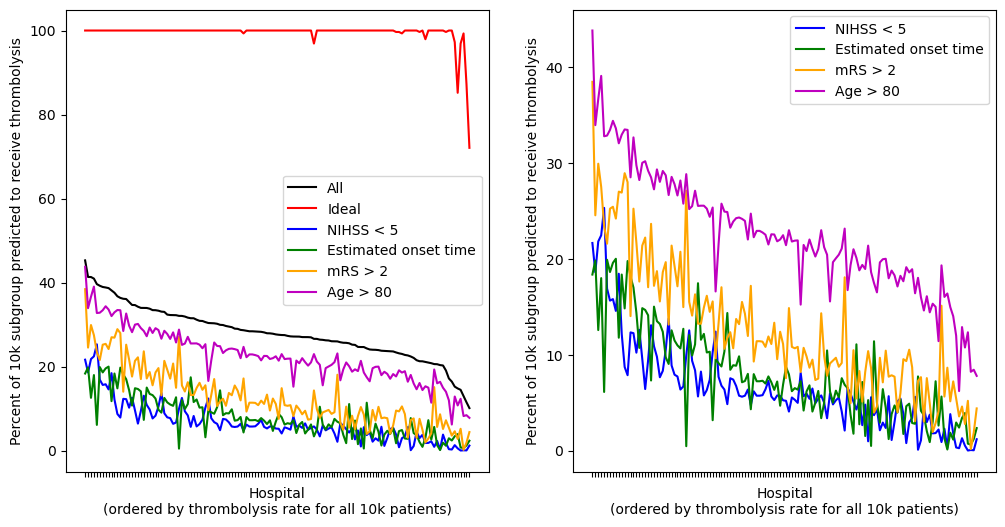

In [85]:
sorted_results = results.sort_values('All patients', ascending=False)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.plot(sorted_results['All patients'], label = 'All', c='k')
ax1.plot(sorted_results['Ideal'], label = 'Ideal', c='r')
ax1.plot(sorted_results['NIHSS < 5'], label = 'NIHSS < 5', c='b')
ax1.plot(sorted_results['Estimated onset time'], label = 'Estimated onset time', c='g')
ax1.plot(sorted_results['mRS > 2'], label = 'mRS > 2', c='orange')
ax1.plot(sorted_results['Age > 80'], label = 'Age > 80', c='m')
ax1.set_xticklabels([])
ax1.legend()
ax1.set_xlabel('Hospital\n(ordered by thrombolysis rate for all 10k patients)')
ax1.set_ylabel('Percent of 10k subgroup predicted to receive thrombolysis')

ax2 = fig.add_subplot(122)
ax2.plot(sorted_results['NIHSS < 5'], label = 'NIHSS < 5', c='b')
ax2.plot(sorted_results['Estimated onset time'], label = 'Estimated onset time', c='g')
ax2.plot(sorted_results['mRS > 2'], label = 'mRS > 2', c='orange')
ax2.plot(sorted_results['Age > 80'], label = 'Age > 80', c='m')
ax2.set_xticklabels([])
ax2.legend()
ax2.set_xlabel('Hospital\n(ordered by thrombolysis rate for all 10k patients)')
ax2.set_ylabel('Percent of 10k subgroup predicted to receive thrombolysis')

plt.savefig('./output/15_10k_subgroup.jpg', dpi=300)

plt.show()

Show all nine individual features

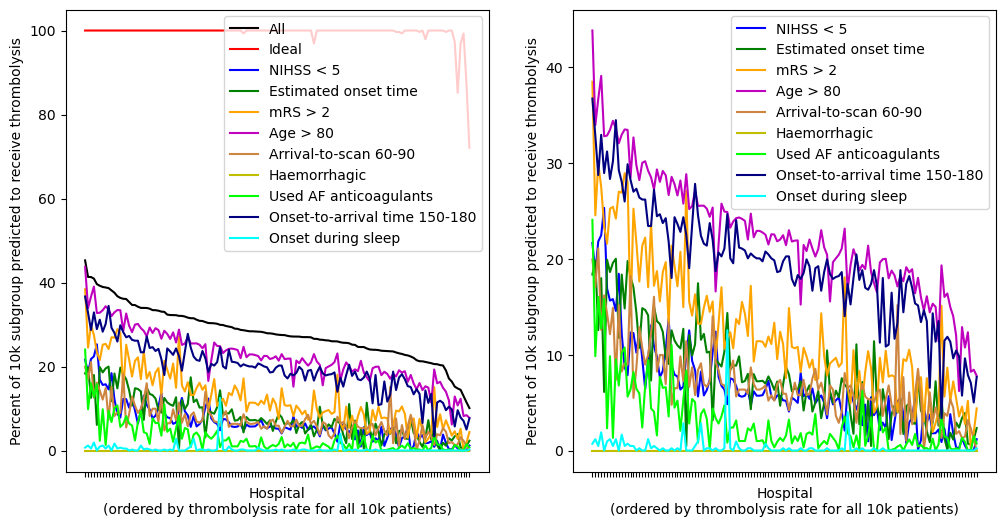

In [86]:
sorted_results = results.sort_values('All patients', ascending=False)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.plot(sorted_results['All patients'], label = 'All', c='k')
ax1.plot(sorted_results['Ideal'], label = 'Ideal', c='r')
ax1.plot(sorted_results['NIHSS < 5'], label = 'NIHSS < 5', c='b')
ax1.plot(sorted_results['Estimated onset time'], label = 'Estimated onset time', c='g')
ax1.plot(sorted_results['mRS > 2'], label = 'mRS > 2', c='orange')
ax1.plot(sorted_results['Age > 80'], label = 'Age > 80', c='m')
ax1.plot(sorted_results['Arrival-to-scan 60-90'], label = 'Arrival-to-scan 60-90', c='peru')
ax1.plot(sorted_results['Haemorrhagic'], label = 'Haemorrhagic', c='y')
ax1.plot(sorted_results['Used AF anticoagulants'], label = 'Used AF anticoagulants', c='lime')
ax1.plot(sorted_results['Onset-to-arrival time 150-180'], label = 'Onset-to-arrival time 150-180', c='navy')
ax1.plot(sorted_results['Onset during sleep'], label = 'Onset during sleep', c='aqua')

ax1.set_xticklabels([])
ax1.legend()
ax1.set_xlabel('Hospital\n(ordered by thrombolysis rate for all 10k patients)')
ax1.set_ylabel('Percent of 10k subgroup predicted to receive thrombolysis')

ax2 = fig.add_subplot(122)
ax2.plot(sorted_results['NIHSS < 5'], label = 'NIHSS < 5', c='b')
ax2.plot(sorted_results['Estimated onset time'], label = 'Estimated onset time', c='g')
ax2.plot(sorted_results['mRS > 2'], label = 'mRS > 2', c='orange')
ax2.plot(sorted_results['Age > 80'], label = 'Age > 80', c='m')
ax2.plot(sorted_results['Arrival-to-scan 60-90'], label = 'Arrival-to-scan 60-90', c='peru')
ax2.plot(sorted_results['Haemorrhagic'], label = 'Haemorrhagic', c='y')
ax2.plot(sorted_results['Used AF anticoagulants'], label = 'Used AF anticoagulants', c='lime')
ax2.plot(sorted_results['Onset-to-arrival time 150-180'], label = 'Onset-to-arrival time 150-180', c='navy')
ax2.plot(sorted_results['Onset during sleep'], label = 'Onset during sleep', c='aqua')
ax2.set_xticklabels([])
ax2.legend()
ax2.set_xlabel('Hospital\n(ordered by thrombolysis rate for all 10k patients)')
ax2.set_ylabel('Percent of 10k subgroup predicted to receive thrombolysis')

plt.savefig(f'./output/{notebook}_{model_text}_subgroup_all_features.jpg', dpi=300)

plt.show()

21 Feb discussion wiht MA:

Patient subgroup Onset during sleep, observed in data is 3% IVT (compared to 30% IVT for all patients arriving within 4 hours).

Based on the SHAP value for onset in sleep (it's comparable to anticoagulant use) we're surprised to see it flat line in these graphs (aqua), whereas anticoagulants drops slowly like the others but on a lower level.

Haemorrahgaic looks right - 0% IVT for all hospitals.

Onset-to-arrival: On RHS are hosptials that give IVT to all patients the least, so hospitals are choosing to not give IVT to more patients, however for the onset-to-arrival subgroup are higher IVT than expect. So not as important feature for between hosptial behaviour.

Next tasks:
1. Check if other two models (all data and kfold) give IVT to the sleep subgroup?
2. Give 10k trianing set to this 15 notebook. Does it show same pattern?
3. Look as SHAP waterfallplot for some of these patients?

## Show a summary of results

In [87]:
results.describe().T

,count,mean,std,min,25%,50%,75%,max
All patients,132.0,27.963636,6.330286,10.100000,23.995000,27.605000,32.052500,45.270000
Ideal,132.0,99.469697,2.974083,72.068966,100.000000,100.000000,100.000000,100.000000
NIHSS < 5,132.0,6.607452,4.802008,0.000000,3.810731,5.672718,7.948478,25.280299
Estimated onset time,132.0,7.915853,5.047863,0.106129,4.119130,7.123906,10.984346,19.978774
mRS > 2,132.0,12.598246,7.096859,0.147929,7.692308,10.798817,16.161243,38.412229
Age > 80,132.0,22.466330,6.523119,6.193853,18.575650,21.938534,25.933806,43.758865
Arrival-to-scan 60-90,132.0,7.067428,3.881265,0.000000,5.303030,6.349206,8.405483,21.067821
Haemorrhagic,132.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Used AF anticoagulants,132.0,3.047819,3.723689,0.000000,0.660611,1.610239,3.860446,24.029727
Onset-to-arrival time 150-180,132.0,19.450893,6.224218,3.370787,16.726251,19.356486,23.416752,36.670072


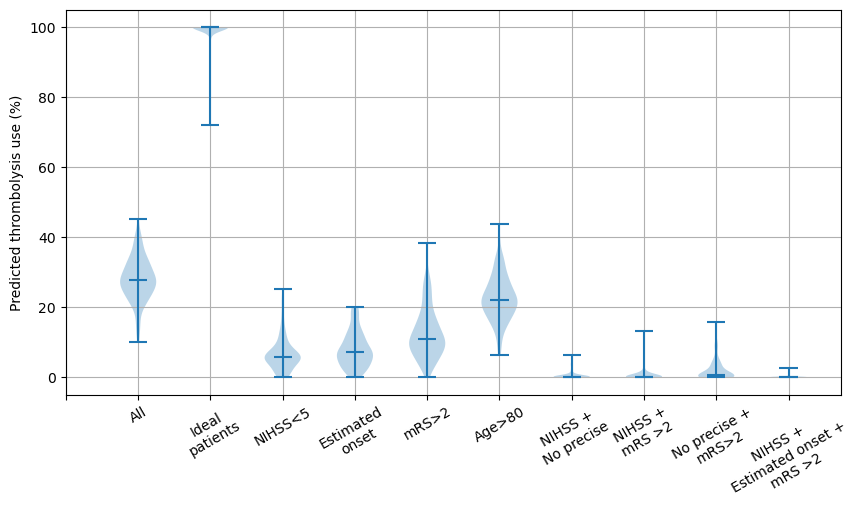

In [88]:
cols = ['All patients', 'Ideal', 'NIHSS < 5', 'Estimated onset time', 'mRS > 2', 'Age > 80',
        'NIHSS + Precise', 'NIHSS + Disability', 'Precise + Disability', 'NIHSS + Precise + Disability']
labels = ['', 'All', 'Ideal\npatients', 'NIHSS<5', 'Estimated\nonset', 'mRS>2', 'Age>80',
          'NIHSS +\nNo precise', 'NIHSS +\nmRS >2', 'No precise +\nmRS>2', 'NIHSS + \nEstimated onset +\nmRS >2']
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.violinplot(results[cols], showmedians=True)
ax.set_ylabel('Predicted thrombolysis use (%)')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=30)
ax.grid()
plt.savefig(f'./output/{notebook}_{model_text}_subgroup_violin.jpg', dpi=300,
    bbox_inches='tight', pad_inches=0.2)
plt.show()

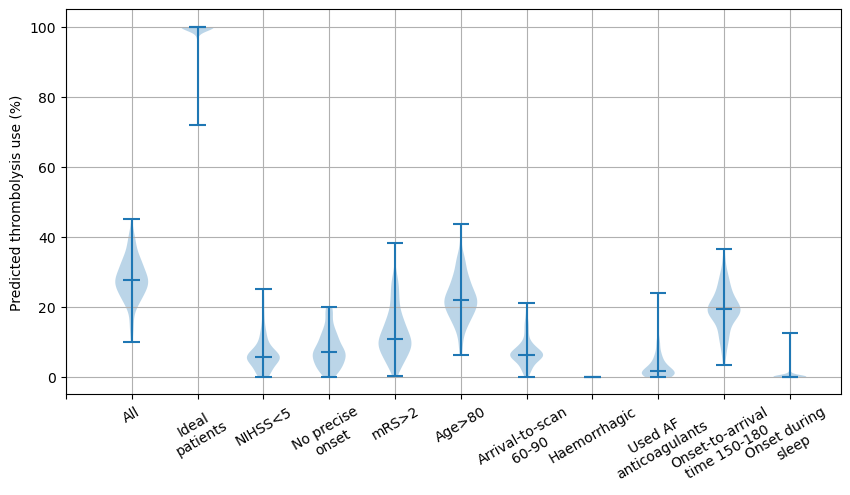

In [89]:
cols = ['All patients', 'Ideal', 'NIHSS < 5', 'Estimated onset time', 'mRS > 2', 'Age > 80',
        'Arrival-to-scan 60-90', 'Haemorrhagic', 'Used AF anticoagulants',
        'Onset-to-arrival time 150-180', 'Onset during sleep']
labels = ['', 'All', 'Ideal\npatients', 'NIHSS<5', 'No precise\nonset', 'mRS>2', 'Age>80',
        'Arrival-to-scan\n60-90', 'Haemorrhagic', 'Used AF\nanticoagulants',
        'Onset-to-arrival\ntime 150-180', 'Onset during\nsleep']

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.violinplot(results[cols], showmedians=True)
ax.set_ylabel('Predicted thrombolysis use (%)')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=30)
ax.grid()
plt.savefig(f'./output/{notebook}_{model_text}_subgroup_violin_all_features.jpg', dpi=300,
    bbox_inches='tight', pad_inches=0.2)
plt.show()

## Check correlations between 10k subgroups

In [90]:
pairs_to_test = [
    ['All patients', 'NIHSS < 5'],
    ['All patients', 'Estimated onset time'],
    ['All patients', 'mRS > 2'],
    ['All patients', 'Age > 80'],
    ['NIHSS < 5', 'Estimated onset time'],
    ['NIHSS < 5', 'mRS > 2'],
    ['NIHSS < 5', 'Age > 80'],
    ['Estimated onset time', 'mRS > 2'],
    ['Estimated onset time', 'Age > 80'],
    ['mRS > 2', 'Age > 80']]

for pair in pairs_to_test:
    slope, intercept, r_value, p_value, std_err = \
        stats.linregress(results[pair[0]],results[pair[1]])
    print (f'Correlation between {pair[0]} and {pair[1]}:'
           f'\n  r-squared = {r_value**2:0.3f}, p = {p_value:0.3f}\n')

Correlation between All patients and NIHSS < 5:
  r-squared = 0.766, p = 0.000

Correlation between All patients and Estimated onset time:
  r-squared = 0.679, p = 0.000

Correlation between All patients and mRS > 2:
  r-squared = 0.774, p = 0.000

Correlation between All patients and Age > 80:
  r-squared = 0.927, p = 0.000

Correlation between NIHSS < 5 and Estimated onset time:
  r-squared = 0.445, p = 0.000

Correlation between NIHSS < 5 and mRS > 2:
  r-squared = 0.621, p = 0.000

Correlation between NIHSS < 5 and Age > 80:
  r-squared = 0.681, p = 0.000

Correlation between Estimated onset time and mRS > 2:
  r-squared = 0.528, p = 0.000

Correlation between Estimated onset time and Age > 80:
  r-squared = 0.654, p = 0.000

Correlation between mRS > 2 and Age > 80:
  r-squared = 0.868, p = 0.000



In [91]:
features = ['NIHSS < 5', 'Estimated onset time', 'mRS > 2', 'Age > 80', 
            'Arrival-to-scan 60-90', 'Haemorrhagic', 'Used AF anticoagulants', 
            'Onset-to-arrival time 150-180','Onset during sleep']
for feat1 in features:
    for feat2 in features[features.index(feat1)+1:]:
        try:
            slope, intercept, r_value, p_value, std_err = \
                stats.linregress(results[feat1],results[feat2])
            print (f'Correlation between {feat1} and {feat2}:'
                f'\n  r-squared = {r_value**2:0.3f}, p = {p_value:0.3f}\n')
        except:
            print ('Correlation cannot be calulated)')

Correlation between NIHSS < 5 and Estimated onset time:
  r-squared = 0.445, p = 0.000

Correlation between NIHSS < 5 and mRS > 2:
  r-squared = 0.621, p = 0.000

Correlation between NIHSS < 5 and Age > 80:
  r-squared = 0.681, p = 0.000

Correlation between NIHSS < 5 and Arrival-to-scan 60-90:
  r-squared = 0.661, p = 0.000

Correlation between NIHSS < 5 and Haemorrhagic:
  r-squared = 0.000, p = 1.000

Correlation between NIHSS < 5 and Used AF anticoagulants:
  r-squared = 0.578, p = 0.000

Correlation between NIHSS < 5 and Onset-to-arrival time 150-180:
  r-squared = 0.665, p = 0.000

Correlation between NIHSS < 5 and Onset during sleep:
  r-squared = 0.017, p = 0.138

Correlation between Estimated onset time and mRS > 2:
  r-squared = 0.528, p = 0.000

Correlation between Estimated onset time and Age > 80:
  r-squared = 0.654, p = 0.000

Correlation between Estimated onset time and Arrival-to-scan 60-90:
  r-squared = 0.319, p = 0.000

Correlation between Estimated onset time and H

## Save results

In [92]:
results.to_csv(f'./output/{notebook}_{model_text}_groups.csv', index=True)

## Look into why not many of subgroup "onset in sleep" get IVT.
Check if patients that have onset in sleep, also have estimated onset time
Think it's a combination that if have onset in sleep then also have estimated onset time, and so the combination of both SHAPs gives minimal chance to have IVT.

In [93]:
# Onset during sleep
mask = test['Onset during sleep'] == 1

print(f'Percent of patients with onset in sleep that have precise onset time: '
      f'{(test["Precise onset time"][mask].mean(axis=0)/test.shape[0])*100}%')

Percent of patients with onset in sleep that have precise onset time: 0.0%


Let's see waterfall plot for one of these patients.

Get SHAP

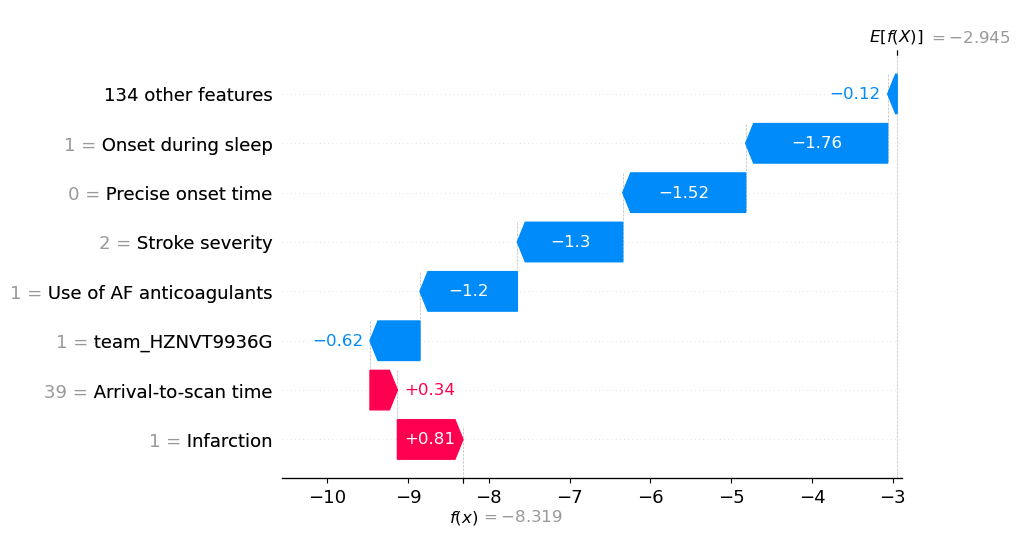

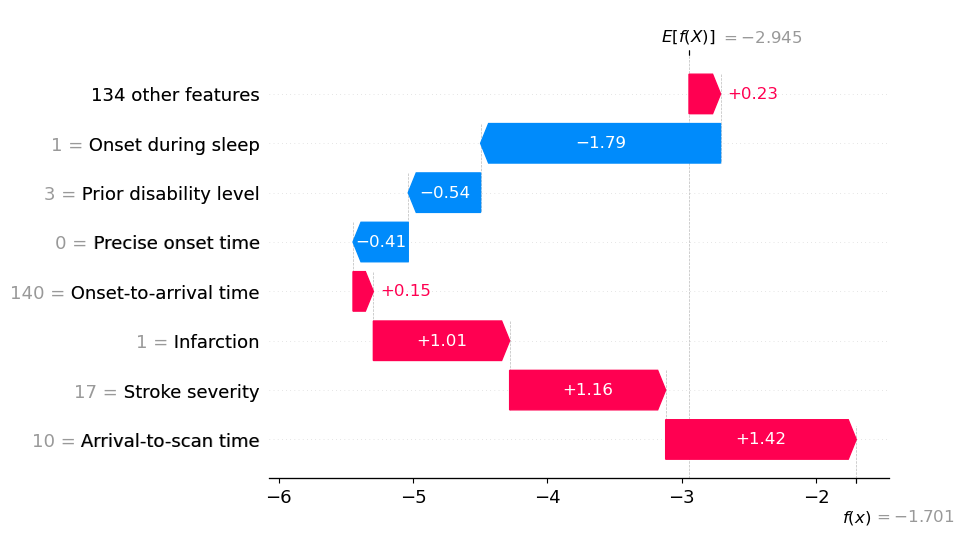

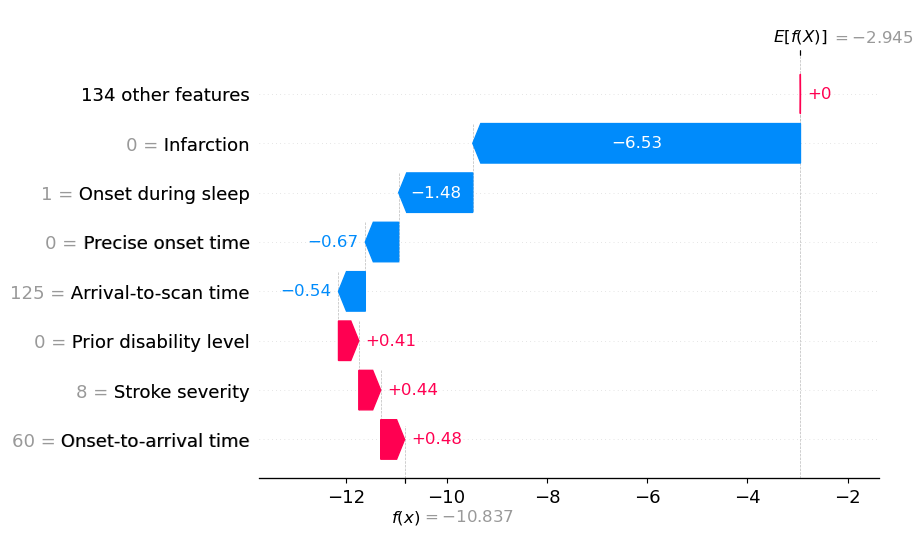

In [94]:
# Set up explainer using the model and feature values from training set
explainer = shap.TreeExplainer(model, X_train)
shap_values_extended = explainer(X_test)

for i in range(3):
    location_onset_during_sleep = np.where(test['Onset during sleep'] == 1)[0][i]

    fig = waterfall.waterfall(shap_values_extended[location_onset_during_sleep], 
                              show=False, max_display=8, 
                              y_reverse=True, rank_absolute=False)
    plt.savefig(f'output/{notebook}_{model_text}_waterfall_onset_during_sleep_{i}.jpg', 
                dpi=300, bbox_inches='tight', pad_inches=0.2)
    plt.show()